**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 50 kB 4.2 MB/s 


In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
print(X_train.shape, X_test.shape)
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()
print(X_train.shape, X_test.shape)

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 3, 32, 32) (10000, 3, 32, 32)



Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
model.vars();

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



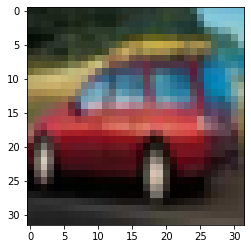

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[-0.24507532  0.69726545]
   [ 0.70371294 -0.20474094]
   [-0.76627636 -0.06370345]]]]
Conv output: [[[[-0.00616123 -0.0049548   0.00166948 ... -0.2499281  -0.23477948
    -0.2248034 ]
   [-0.0182255  -0.01495302 -0.01039478 ... -0.24009952 -0.22748552
    -0.2262791 ]
   [-0.01943193 -0.01219336 -0.01642692 ... -0.22051989 -0.21295483
    -0.22135557]
   ...
   [-0.05308276 -0.05066991 -0.05066991 ... -0.05374492 -0.05495134
    -0.05857061]
   [-0.04463778 -0.04222493 -0.04222493 ... -0.06098346 -0.05977703
    -0.05977703]
   [-0.03981208 -0.03860565 -0.03981208 ... -0.07787345 -0.07666701
    -0.07304773]]

  [[ 0.03014929  0.02846764  0.0236725  ...  0.11619695  0.11004584
     0.10806093]
   [ 0.0469658   0.03936044  0.04048901 ...  0.14637335  0.13513257
     0.1334509 ]
   [ 0.04864746  0.03855754  0.04889727 ...  0.18045731  0.16598251
     0.1599383 ]
   ...
   [ 0.07399265  0.07062936  0.07062936 ...  0.12880954  0.13049118
     0.13553615]
   [ 0.06222109

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
def my_conv_net(my_image, initial_filter_weights):
  #n = number of examples in a batch 32
  #c = number of channels/colors 3
  #h = height 32
  #w = width 32
  #vec = [1,1,3,  2]
  #vec = [k,k,cin,cout]
  
  #height of output image 
  H_out = my_image.shape[2] - initial_filter_weights.shape[0] + 1
  #width of output image
  W_out = my_image.shape[3] - initial_filter_weights.shape[1] + 1

  my_conv_output = np.zeros([my_image.shape[0], initial_filter_weights.shape[3], H_out, W_out])
  
  for n in range(my_conv_output.shape[0]): #n = 1
    for cout in range(my_conv_output.shape[1]): #cout = 0 1 
      for i in range(my_conv_output.shape[2]): #i = 0 - 31
        for j in range(my_conv_output.shape[3]): #j = 0 -31
          my_conv_output[n, cout, i, j] = np.multiply(my_image[n,:, i, j], initial_filter_weights[:,:,:,cout]).sum()    
  return my_conv_output

my_conv_output = my_conv_net(my_image, filter_weights)
print(my_conv_output)
print(my_conv_output.shape)


[[[[-0.00616123 -0.00495481  0.00166948 ... -0.2499281  -0.23477949
    -0.22480339]
   [-0.0182255  -0.01495302 -0.01039479 ... -0.24009952 -0.22748553
    -0.2262791 ]
   [-0.01943192 -0.01219336 -0.01642692 ... -0.22051988 -0.21295482
    -0.22135556]
   ...
   [-0.05308276 -0.05066991 -0.05066991 ... -0.05374491 -0.05495133
    -0.05857061]
   [-0.04463778 -0.04222492 -0.04222492 ... -0.06098347 -0.05977704
    -0.05977704]
   [-0.03981207 -0.03860565 -0.03981207 ... -0.07787344 -0.07666701
    -0.07304773]]

  [[ 0.03014929  0.02846764  0.0236725  ...  0.11619698  0.11004585
     0.10806093]
   [ 0.0469658   0.03936045  0.04048901 ...  0.14637332  0.13513255
     0.1334509 ]
   [ 0.04864745  0.03855754  0.04889727 ...  0.18045729  0.16598251
     0.15993829]
   ...
   [ 0.07399265  0.07062935  0.07062935 ...  0.12880952  0.13049117
     0.13553613]
   [ 0.06222109  0.05885779  0.05885779 ...  0.13889943  0.13721778
     0.13721778]
   [ 0.05549449  0.05381284  0.05549449 ...  0.16

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[-0.08725689,  0.16054041]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
#OBJAX LINEAR LAYER: 
out_new = my_conv_output.mean((2,3))

objax_lin_layer = objax.nn.Linear(out_new.shape[1], 1)
x = out_new 
y = objax_lin_layer(out_new)
w = objax_lin_layer.w.value
b = objax_lin_layer.b.value

#OWN LINEAR LAYER:
my_y = np.sum(np.multiply(w.T, x)) + b[0] 

print(y)
print(my_y)

[[-0.08442281]]
-0.08442281


You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)                    
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.03 Validation Accuracy 10.32
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.30 Validation Accuracy 10.80
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 11.14 Validation Accuracy 12.80
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 13.06 Validation Accuracy 13.37
Epoch 0005  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 13.24 Validation Accuracy 13.82
Epoch 0006  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.59 Validation Accuracy 13.75
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.57 Validation Accuracy 14.17
Epoch 0008  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 14.19 Validation Accuracy 15.10
Epoch 0009  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 14.72 Validation Accuracy 15.95
Epoch 0010  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 15.52 Valida

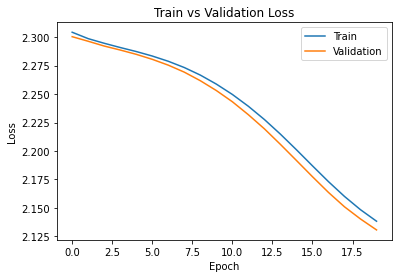

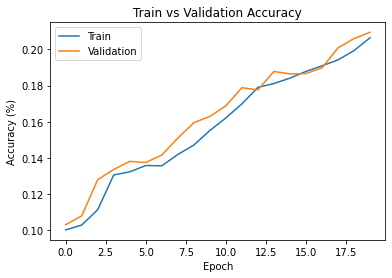

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

#### Question 5: 
Chosen Hyperparameters:

*   Epochs
*   Batch Size 
*   Learning Rate 
*   Number of Outputs of Conv Layer 1

H1 = {Epochs = 10, Batch Size = 100, Learning Rate = 0.1, Out Conv 1 = 8}

H2 = {Epochs = 20, Batch Size = 5, Learning Rate = 0.001, Out Conv 1 = 20}

#### Question 6:  


Epoch 0001  Training Loss 2.19 Validation Loss 2.10 Training Accuracy 20.29 Validation Accuracy 21.85
Epoch 0002  Training Loss 2.08 Validation Loss 2.04 Training Accuracy 24.19 Validation Accuracy 25.72
Epoch 0003  Training Loss 2.04 Validation Loss 2.01 Training Accuracy 26.89 Validation Accuracy 24.65
Epoch 0004  Training Loss 1.99 Validation Loss 1.97 Training Accuracy 29.07 Validation Accuracy 27.67
Epoch 0005  Training Loss 1.96 Validation Loss 1.94 Training Accuracy 30.66 Validation Accuracy 28.98
Epoch 0006  Training Loss 1.92 Validation Loss 1.89 Training Accuracy 32.53 Validation Accuracy 30.62
Epoch 0007  Training Loss 1.89 Validation Loss 1.89 Training Accuracy 33.41 Validation Accuracy 29.43
Epoch 0008  Training Loss 1.87 Validation Loss 1.89 Training Accuracy 34.09 Validation Accuracy 29.02
Epoch 0009  Training Loss 1.85 Validation Loss 1.83 Training Accuracy 34.78 Validation Accuracy 32.67
Epoch 0010  Training Loss 1.83 Validation Loss 1.82 Training Accuracy 35.79 Valida

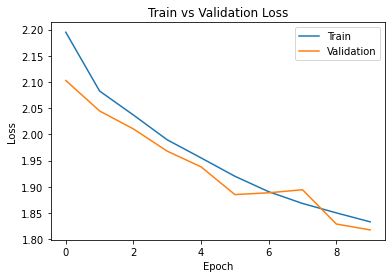

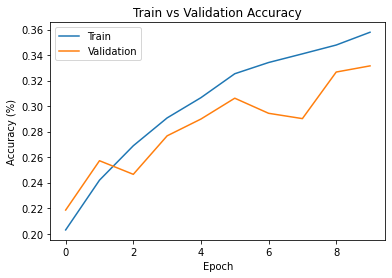

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)
  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x
M1_model = ConvNet()

def loss_function(x, labels):
    logit = M1_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict = objax.Jit(lambda x: objax.functional.softmax(M1_model(x)), M1_model.vars()) 
gv= objax.GradValues(loss_function, M1_model.vars())
tv = objax.ModuleList(objax.TrainRef(x) for x in M1_model.vars().subset(objax.TrainVar))

def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)  
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)                    
    return loss_value                      

train_op = objax.Jit(train_op, gv.vars() + tv.vars())

train(EPOCHS=10, BATCH=100, LEARNING_RATE=0.1)

Epoch 0001  Training Loss 2.29 Validation Loss 2.27 Training Accuracy 12.30 Validation Accuracy 15.45
Epoch 0002  Training Loss 2.25 Validation Loss 2.22 Training Accuracy 16.39 Validation Accuracy 18.52
Epoch 0003  Training Loss 2.19 Validation Loss 2.14 Training Accuracy 19.23 Validation Accuracy 19.75
Epoch 0004  Training Loss 2.12 Validation Loss 2.10 Training Accuracy 21.14 Validation Accuracy 22.73
Epoch 0005  Training Loss 2.10 Validation Loss 2.09 Training Accuracy 22.68 Validation Accuracy 22.47
Epoch 0006  Training Loss 2.08 Validation Loss 2.07 Training Accuracy 23.47 Validation Accuracy 24.53
Epoch 0007  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 24.14 Validation Accuracy 24.60
Epoch 0008  Training Loss 2.05 Validation Loss 2.04 Training Accuracy 25.23 Validation Accuracy 24.42
Epoch 0009  Training Loss 2.03 Validation Loss 2.02 Training Accuracy 25.90 Validation Accuracy 24.82
Epoch 0010  Training Loss 2.02 Validation Loss 2.01 Training Accuracy 26.40 Valida

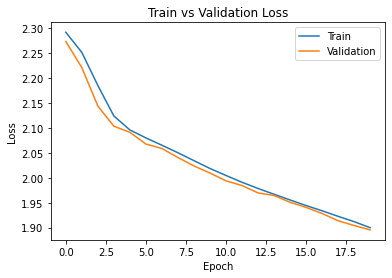

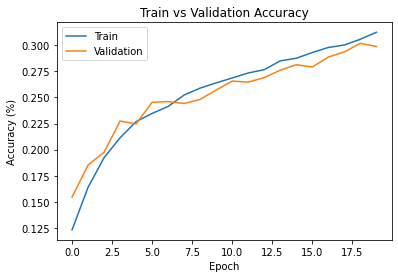

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 20, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(20, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)
  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x
M2_model = ConvNet()

def loss_function(x, labels):
    logit = M2_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict = objax.Jit(lambda x: objax.functional.softmax(M2_model(x)), M2_model.vars()) 
gv= objax.GradValues(loss_function, M2_model.vars())
tv = objax.ModuleList(objax.TrainRef(x) for x in M2_model.vars().subset(objax.TrainVar))

def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)  
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)                    
    return loss_value                      

train_op = objax.Jit(train_op, gv.vars() + tv.vars())

train(EPOCHS=20, BATCH=5, LEARNING_RATE=0.001)

My M1_model performs the best in terms of validation accuracy. As seen above : 

The base model achieves it's highest validation accuracy of 20.95% at EPOCH 20. 

The M1_model achieves it's highest validation accuracy of 33.15% at EPOCH 10. 

The M2_model achieves it's highest validation accuracy of 30.18% at EPOCH 19. 

You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [ ]:
#importing and partitioning the data from MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#reshaping and scaling the data. Due to a previous error, i learned that I have to change the uint8 to float32.
x_train = x_train[:,None,:,:]
x_train = x_train.astype('float32') #i got an error later in my code that led me to this edit. 
x_test = x_test[:,None,:,:]
x_test = x_test.astype('float32')
y_train = y_train.flatten()
y_test = y_test.flatten()

np.random.seed(2)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
x_data = np.concatenate([x_train, x_test], axis = 0)
y_data = np.concatenate([y_train, y_test], axis = 0)

N = np.arange(len(x_data))
np.random.shuffle(N)
x_data = x_data[N]
y_data = y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(x_data) * train_ratio)
n_valid = int(len(x_data) * valid_ratio)

x_train, x_valid, x_test = x_data[:n_train], x_data[n_train:n_train+n_valid], x_data[n_train+n_valid:]
y_train, y_valid, y_test = y_data[:n_train], y_data[n_train:n_train+n_valid], y_data[n_train+n_valid:]

In [ ]:
x_train.shape, x_test.shape

((56000, 1, 28, 28), (7000, 1, 28, 28))

In [ ]:
y_train.shape, y_test.shape

((56000,), (7000,))

In [ ]:
#baseline model
class persConvNet(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
my_model = persConvNet()
#You can examine the architecture of our CNN by calling model.vars()
my_model.vars()

{'(persConvNet).conv_1(Sequential)[0](Conv2D).b': objax.TrainVar(DeviceArray([[[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]]], dtype=float32), reduce=reduce_mean),
 '(persConvNet).conv_1(Sequential)[0](Conv2D).w': objax.TrainVar(DeviceArray([[[[-0.13122825,  0.08154106,  0.19258802,  0.32389262,
                 -0.60705876,  0.25427228, -0.37259564,  0.72

In [ ]:
#obtaining baseline model validation accuracy 

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = my_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(my_model(x)), my_model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, my_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in my_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)                    
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(x_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, x_train.shape[0], BATCH):
          batch = train_indices[0:32]
          avg_train_loss += float(train_op(x_train[batch], y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(x_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == y_train[batch]).sum()
      train_acc_epoch.append(train_acc/x_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/x_train.shape[0])

      # run validation
      val_indices = np.arange(len(x_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, x_valid.shape[0], BATCH):
          batch = val_indices[0:32]
          avg_val_loss += float(loss_function(x_valid[batch], y_valid[batch])) * len(batch)
          val_prediction = predict(x_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/x_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/x_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [ ]:
train()

Epoch 0001  Training Loss 1.04 Validation Loss 3.13 Training Accuracy 97.82 Validation Accuracy 32.85
Epoch 0002  Training Loss 0.63 Validation Loss 2.71 Training Accuracy 103.90 Validation Accuracy 36.50
Epoch 0003  Training Loss 0.34 Validation Loss 2.59 Training Accuracy 111.17 Validation Accuracy 43.80
Epoch 0004  Training Loss 0.31 Validation Loss 2.65 Training Accuracy 110.62 Validation Accuracy 62.05
Epoch 0005  Training Loss 0.29 Validation Loss 3.52 Training Accuracy 111.03 Validation Accuracy 43.80
Epoch 0006  Training Loss 0.25 Validation Loss 2.44 Training Accuracy 112.27 Validation Accuracy 54.75


KeyboardInterrupt: ignored